<a href="https://colab.research.google.com/github/anastefan176/ULEZ/blob/main/Final_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pylab
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

pylab.rcParams['figure.figsize'] = (10., 8.)

In [ ]:
from google.colab import files
uploaded = files.upload()

data = pd.read_csv('LaqnData (4).csv')
data.head()

Saving LaqnData (4).csv to LaqnData (4) (1).csv


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,ST5,NO2,01/01/2020 00:00,35.3,ug m-3,R
1,ST5,NO2,02/01/2020 00:00,19.6,ug m-3,R
2,ST5,NO2,03/01/2020 00:00,32.7,ug m-3,R
3,ST5,NO2,04/01/2020 00:00,22.8,ug m-3,R
4,ST5,NO2,05/01/2020 00:00,13.2,ug m-3,R


In [ ]:

data.columns = [col.strip().lower().replace(' ', '_') for col in data.columns]
print("Columns:", data.columns.tolist())

expected_cols = ['site', 'readingdatetime', 'value', 'units']
data = data[[col for col in expected_cols if col in data.columns]]


if 'readingdatetime' in data.columns:
    data = data.rename(columns={'readingdatetime': 'datetime'})


data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce', dayfirst=True)
data['value'] = pd.to_numeric(data['value'], errors='coerce')


data = data.dropna(subset=['datetime', 'value'])


data = data[(data['value'] >= 0) & (data['value'] <= 200)]

data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month


data = data[(data['year'] >= 2020) & (data['year'] <= 2025)]


data['post_ulez'] = (data['year'] >= 2023).astype(int)


ulez_map = {
    'BG2': 'Outer',
    'HV1': 'Outer',
    'KC5': 'Outer',
    'ST4': 'Outer',
    'IS1': 'Control',   }

data['zone'] = data['site'].map(ulez_map)

data = data.dropna(subset=['zone'])

print("\nCleaned data summary:")
print(data.info())
print("\nUnique sites:", data['site'].unique())
print("\nDate range:", data['datetime'].min(), "→", data['datetime'].max())
data.head()

Columns: ['site', 'species', 'readingdatetime', 'value', 'units', 'provisional_or_ratified']

Cleaned data summary:
<class 'pandas.core.frame.DataFrame'>
Index: 2106 entries, 2130 to 4250
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   site       2106 non-null   object        
 1   datetime   2106 non-null   datetime64[ns]
 2   value      2106 non-null   float64       
 3   units      2106 non-null   object        
 4   year       2106 non-null   int32         
 5   month      2106 non-null   int32         
 6   post_ulez  2106 non-null   int64         
 7   zone       2106 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(3)
memory usage: 131.6+ KB
None

Unique sites: ['HV1']

Date range: 2020-01-01 00:00:00 → 2025-10-21 00:00:00


,site,datetime,value,units,year,month,post_ulez,zone
2130,HV1,2020-01-01,41.1,ug m-3,2020,1,0,Outer
2131,HV1,2020-01-02,21.1,ug m-3,2020,1,0,Outer
2132,HV1,2020-01-03,28.1,ug m-3,2020,1,0,Outer
2133,HV1,2020-01-04,41.9,ug m-3,2020,1,0,Outer
2134,HV1,2020-01-05,26.7,ug m-3,2020,1,0,Outer


In [ ]:

yearly_means = (
    data.groupby(['site', 'year', 'zone', 'post_ulez'])['value']
    .mean()
    .reset_index()
)

print("Yearly means per site:")
print(yearly_means.head())


Yearly means per site:
  site  year   zone  post_ulez      value
0  HV1  2020  Outer          0  22.548361
1  HV1  2021  Outer          0  22.550139
2  HV1  2022  Outer          0  22.879224
3  HV1  2023  Outer          1  20.461453
4  HV1  2024  Outer          1  18.997268


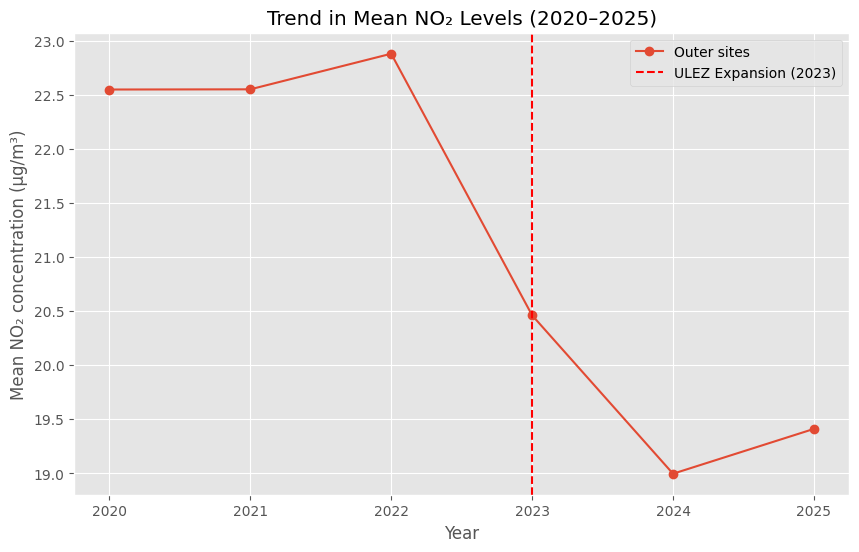

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for zone, df_zone in yearly_means.groupby('zone'):
    plt.plot(df_zone['year'], df_zone['value'], marker='o', label=f"{zone} sites")


plt.axvline(x=2023, color='red', linestyle='--', label='ULEZ Expansion (2023)')

plt.title('Trend in Mean NO₂ Levels (2020–2025)')
plt.xlabel('Year')
plt.ylabel('Mean NO₂ concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import statsmodels.formula.api as smf

model = smf.ols('value ~ year + post_ulez + C(zone)', data=yearly_means).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     19.33
Date:                Mon, 10 Nov 2025   Prob (F-statistic):             0.0193
Time:                        18:29:54   Log-Likelihood:                -3.3764
No. Observations:                   6   AIC:                             12.75
Df Residuals:                       3   BIC:                             12.13
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    385.9462    607.026      0.636      0.5

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
